In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "6" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "6" # export OPENBLAS_NUM_THREADS=4
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6

In [2]:
from matplotlib import pyplot as plt

import torch
from torch import nn

from omegaconf import OmegaConf
from ase.visualize.plot import plot_atoms
from ase import Atoms
from schnetpack import properties
from schnetpack.model import NeuralNetworkPotential
import schnetpack.transform as trn
from schnetpack.datasets import QM9
from tqdm import tqdm
import ase

from morered.datasets import QM9Filtered, QM7X
from morered.noise_schedules import PolynomialSchedule, CosineSchedule
from morered.processes import VPGaussianDDPM
from morered.utils import scatter_mean, check_validity, generate_bonds_data, batch_center_systems, batch_rmsd
from morered.sampling import DDPM, MoreRedJT, MoreRedAS, MoreRedITP, ConsistencySampler
from morered import ReverseODE

# Paths

In [3]:
# path to store the dataset as ASE '.db' files
split_file_path = "./split.npz"

# model path
models_path = "../models"

# Load model

In [4]:
# time predictor
time_predictor = torch.load(os.path.join(models_path, "qm7x_time_predictor.pt"), map_location="cpu")

/tmp/ipykernel_332786/3042508950.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  time_predictor = torch.load(os.path.join(models_path, "qm7x_time_predictor.pt"), map_loc

# Define sampler

In [56]:
# define the noise schedule
T = 128
noise_schedule = PolynomialSchedule(T=T, s=1e-5, dtype=torch.float64, variance_type="lower_bound")

# define the forward diffusion process
diff_proc = VPGaussianDDPM(noise_schedule, noise_key="eps", invariant=True, dtype=torch.float64)

# Define data loader

Define paths

In [57]:
tut_path = "./tut"

In [58]:
os.makedirs(tut_path, exist_ok=True)

Define data input transformations

QM7X

NOTE! QM7-X is large. Therefore, it takes time to download the dataset and prepare it

In [59]:
transforms=[
    trn.CastTo64(),
    trn.SubtractCenterOfGeometry(),
]

In [60]:
# path to store the dataset as ASE '.db' files
datapath = os.path.join(tut_path, "qm7x.db")

In [61]:
data = QM7X(
    datapath=datapath,
    only_equilibrium=True,
    batch_size=1,
    split_file=split_file_path,
    transforms=transforms,
    num_workers=2,
    pin_memory=False,
    load_properties=["rmsd"],
)

Prepare dataset

In [62]:
# prepare and setup the dataset
data.prepare_data()
data.setup()

# Representation Loss

Load a batch

In [63]:
# train split here is not the same as during training
target = next(iter(data.test_dataloader()))

In [64]:
representation = torch.nn.Sequential(trn.CastTo32(), time_predictor.input_modules[0], trn.CastTo32(), time_predictor.representation)
rode = ReverseODE(diff_proc, time_predictor)
# representation = NeuralNetworkPotential(
#     input_modules=time_predictor.input_modules, 
#     representation=time_predictor.representation,
#     output_modules=nn.ModuleList([nn.Identity()])
# )

In [65]:
timesteps = torch.arange(T).unsqueeze(-1).unsqueeze(-1)
traj, _ = diff_proc.diffuse(target[properties.R], idx_m = None, t=timesteps)

In [104]:
n = target[properties.n_atoms][0]
def vector_norm_loss(target, pred):
    diff = pred['vector_representation'] - target['vector_representation']
    return diff.detach().norm(dim=1).square().mean() / n

def vector_loss(target, pred):
    diff = pred['vector_representation'] - target['vector_representation']
    return diff.detach().norm().square() / n

def scalar_loss(target, pred):
    diff = pred['scalar_representation'] - target['scalar_representation']
    return diff.detach().norm().square() / n


In [105]:
batch = {key: val.clone() for key, val in target.items()}

target_hat = rode.prepare_batch(target)
target_reprs = representation(target_hat)

vector_norm_losses = []
vector_losses = []
scalar_losses = []
for i in range(T):
    batch[properties.R] = traj[i]
    batch_hat = rode.prepare_batch(batch)
    batch_reprs = representation(batch_hat)
    
    vector_norm_losses.append(vector_norm_loss(target_reprs, batch_reprs))
    vector_losses.append(vector_loss(target_reprs, batch_reprs))
    scalar_losses.append(scalar_loss(target_reprs, batch_reprs))

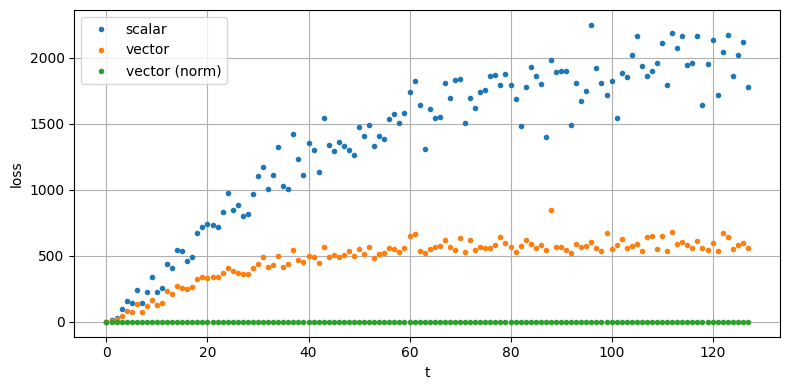

In [106]:
plt.figure(figsize=(8, 4))
plt.xlabel(r"t")
plt.ylabel(r"loss")

plt.plot(scalar_losses, '.', label='scalar')
plt.plot(vector_losses, '.', label='vector')
plt.plot(vector_norm_losses, '.', label='vector (norm)')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Tinkering

In [107]:
batch = {key: val.clone() for key, val in target.items()}
batch[properties.R], _ = diff_proc.diffuse(batch[properties.R], batch[properties.idx_m], t=torch.tensor(1))
n = batch[properties.R].shape[0]

In [108]:
alpha = torch.tensor(torch.pi)
rot_m = torch.Tensor(
    [
    [torch.cos(alpha), - torch.sin(alpha), 0],
    [torch.sin(alpha),    torch.cos(alpha), 0],
    [0,                   0,                1]
    ]
).double()

In [109]:
rotated = {key: val.clone() for key, val in target.items()}
rotated[properties.R] = target[properties.R] @ rot_m
rotated_hat = rode.prepare_batch(rotated)

In [110]:
rotated_reprs = representation(rotated_hat)

In [111]:
print(f"vector loss: {vector_loss(target_reprs, rotated_reprs)}, scalar loss: {scalar_loss(target_reprs, rotated_reprs)}")

vector loss: 1390.33935546875, scalar loss: 1.6112056133721353e-10


In [112]:
permuted = {key: val.clone() for key, val in target.items()}
# for i in range(n):
#     for j in range(i):
#         if permuted[properties.Z][i] == permuted[properties.Z][j]:
#             permuted[properties.R][i, :], permuted[properties.R][j, :] = permuted[properties.R][j, :], permuted[properties.R][i, :]
# permuted[properties.R][-2, :], permuted[properties.R][-1, :] = permuted[properties.R][-1, :], permuted[properties.R][-2, :]
permuted_hat = rode.prepare_batch(permuted)